In [1]:
import os
import json
import time

import numpy as np
import torch
import torchvision
from torchsummary import summary

from project_18408.datasets import *
from project_18408.evaluation import *
from project_18408.experiments import *
from project_18408.utils import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version: 1.8.0
Torchvision Version: 0.9.0
Using the GPU!


In [3]:
def random_sample_ball(radius, num_samples, d):
    output_samples = np.random.normal(size=(num_samples,d)) 
    output_samples = (output_samples.T / np.linalg.norm(output_samples, axis=1)).T
    random_radii = np.random.random(num_samples) ** (1/d)
    output_samples = np.multiply(output_samples, random_radii[:, np.newaxis])
    return output_samples * radius

def random_sample_binary(num_samples, d):
    return np.random.choice([1, -1], (num_samples, d))

In [4]:
def dec_to_bin(x):
    return np.array([2*int(a)-1 for a in list(bin(x)[2:])])

def all_sample_binary(d):
    output_samples = np.zeros((2**d, d))
    for i in range(2**d):
        xi = dec_to_bin(i)
        xi = np.pad(xi, (d - len(xi), 0), mode='constant', constant_values=-1)
        output_samples[i] = xi
    return output_samples.T


In [5]:
def train_model(
    device,
    model,
    dataloaders,
    criterion,
    optimizer,
    w_norm_prod_bound,
    num_epochs=1):
    start_time = time.time()
    
    train_loss_record = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_count = 0
        stop = False
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                # Get model outputs and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                train_loss_record.append(loss.detach().item())
                loss.backward()
                optimizer.step()
            running_loss += loss.detach().item() * inputs.size(0)
            running_count += inputs.size(0)
            training_loss = running_loss / running_count
            if get_weight_norm_prod(model) > w_norm_prod_bound:
                stop = True
                break
            del loss
        if stop:
            break
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    time_elapsed = time.time() - start_time
    return train_loss_record

In [6]:
def get_weight_norm_prod(model):
    prod = 1
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            v = layer.weight.norm().item()
            prod *= v
    return prod

In [7]:
def criterion(output, target):
    loss = -torch.abs(torch.matmul(output.T, target)[0])
    return loss

In [8]:
data_dir = get_rel_pkg_path("dataset/")
weights_dir = get_rel_pkg_path("weights/")
session_dir = get_rel_pkg_path("sessions/")

In [9]:
rc_trials = 5
depths_to_test = list(range(2, 10))
rc_per_depth_samples = []

In [10]:
for _ in range(rc_trials):
    num_samples_bin = 2**5
    num_samples_input = 5
    input_dim = 5
    ball_radius = 1
    w_norm_prod_bound = 10
    network_width = 5

    input_samples = random_sample_ball(ball_radius, num_samples_input, input_dim)
    string_samples = random_sample_binary(num_samples_input, num_samples_bin)
    string_samples = all_sample_binary(num_samples_input)

    rc_per_depth = []

    for d in depths_to_test:
        prods = []
        for n in tqdm(range(num_samples_bin)):
            batch_size = num_samples_input
            target_samples = string_samples[:, n]
            dataset = RawDataset(input_samples.astype(np.float32), target_samples.astype(np.float32))
            dataloader = DataLoader(dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=False)
            dataloaders = {'train': dataloader, 'test': dataloader}
            model = ReLUToyModel(input_dim, 1, layer_dims=[network_width]*(d - 1), bias=False)
            model = model.to(device)
            optimizer = make_optimizer(model, optimzer_type=OptimizerType.SGD_MOMENTUM,
                                   lr=0.01, weight_decay=0, verbose=False, clip_grad_norm=True)
            loss_history = train_model(device=device,
                              model=model,
                              dataloaders=dataloaders,
                              criterion=criterion,
                              optimizer=optimizer,
                              w_norm_prod_bound=w_norm_prod_bound,
                              num_epochs=100)
            max_dot_prod = -loss_history[-2]
            prods.append(max_dot_prod)
        rc_per_depth.append(np.mean(prods))
    rc_per_depth_samples.append(rc_per_depth)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.39it/s]


In [12]:
plt.rcParams.update({'font.size': 12})

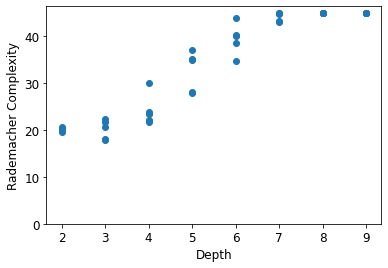

In [13]:
depths = []
rcs = []
for i in range(rc_trials):
    for j in range(len(depths_to_test)):
        depths.append(depths_to_test[j])
        rcs.append(rc_per_depth_samples[i][j])

plt.scatter(depths, rcs)
plt.ylim(bottom=0)
plt.xlabel("Depth")
plt.ylabel("Rademacher Complexity")
plt.show()